<a href="https://colab.research.google.com/github/sfansaria/Stress_Detection/blob/main/Stress_Sentiment_Detection_nltk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the Google drive

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import the Libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

from pandas.io.parsers.readers import TextFileReader
#prepare the text column of the dataset to clean the text column with stopwords,links,special symbols and language errors

import nltk
import re
from nltk.corpus import stopwords
import string


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_score, accuracy_score


#Load the dataset

In [77]:
data = pd.read_csv('/content/drive/My Drive/ml_datasets/stress.csv')

data.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [78]:
data.shape

(2838, 116)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB


#Categorical Columns

In [80]:
print("Categorical columns :")
data.select_dtypes(include=['object']).apply(pd.Series.nunique,axis=0)

Categorical columns :


,0
subreddit,10
post_id,2343
sentence_range,173
text,2820


#Numerical Columns

In [81]:
print("Numerical columns :")
data.select_dtypes(include=['int64']).apply(pd.Series.nunique,axis=0)

Numerical columns :


,0
id,2838
label,2
social_timestamp,2343
social_karma,135
lex_liwc_WC,198
social_num_comments,94


#Floating Numbers Column

In [82]:
print("Floating Numbers columns :")
data.select_dtypes(include=['float64']).apply(pd.Series.nunique,axis=0)

Floating Numbers columns :


,0
confidence,10
syntax_ari,2659
lex_liwc_Analytic,1435
lex_liwc_Clout,1323
lex_liwc_Authentic,978
...,...
lex_dal_avg_imagery,2111
lex_dal_avg_pleasantness,2615
social_upvote_ratio,73
syntax_fk_grade,2417


#Check for Missing data

In [57]:


data.isnull().sum()

,0
subreddit,0
post_id,0
sentence_range,0
text,0
id,0
...,...
lex_dal_avg_pleasantness,0
social_upvote_ratio,0
social_num_comments,0
syntax_fk_grade,0


#Determine the Sentiment Polarity from Words

In [83]:


#Positive Sentiments
print("Positive Sentiment :")
print("Polarity : ",TextBlob("greatest").polarity)
print("Sentiment : ",TextBlob("greatest").sentiment)
print("--------:-)")

#Negative Sentiments
print("Negative Sentiment :")
print("Polarity : ",TextBlob("worst").polarity)
print("Sentiment : ",TextBlob("worst").sentiment)
print("--------:-(")

Positive Sentiment :
Polarity :  1.0
Sentiment :  Sentiment(polarity=1.0, subjectivity=1.0)
--------:-)
Negative Sentiment :
Polarity :  -1.0
Sentiment :  Sentiment(polarity=-1.0, subjectivity=1.0)
--------:-(


#Stress Sentiment Detection

In [84]:

def mood(txt):
  return TextBlob(txt).sentiment.polarity

#Get the Text

In [87]:
posts = data[["text"]]

#Adding Mood Detection as a column

In [92]:

posts["sentiment"] = posts["text"].apply(mood)
posts.head()

<ipython-input-92-e2804ba96e89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["sentiment"] = posts["text"].apply(mood)


,text,sentiment
0,"He said he had not felt that way before, sugge...",-0.002742
1,"Hey there r/assistance, Not sure if this is th...",0.292857
2,My mom then hit me with the newspaper and it s...,0.011894
3,"until i met my new boyfriend, he is amazing, h...",0.141671
4,October is Domestic Violence Awareness Month a...,-0.204167


#Plotting Sentiment against Frequency

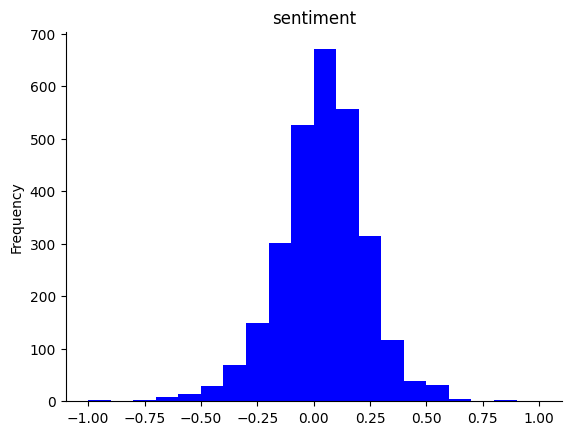

In [96]:
posts['sentiment'].plot(kind='hist', bins=20, title='sentiment',color='blue')
plt.gca().spines[['top', 'right',]].set_visible(False)

#Value Exploration

In [97]:
print("Value Exploration :")
print("Minimum Sentiment :", posts["sentiment"].min())
print("Maximum Sentiment :", posts["sentiment"].max())
print("----------------------")
print("Counts :")
print(posts.sentiment.value_counts())

Value Exploration :
Minimum Sentiment : -1.0
Maximum Sentiment : 1.0
----------------------
Counts :
sentiment
0.000000    63
0.250000    21
0.100000    19
0.175000    14
0.166667    12
            ..
0.038095     1
0.032727     1
0.166171     1
0.095833     1
0.016667     1
Name: count, Length: 2137, dtype: int64


#Preparing the text column of the dataset to clean the text column with stopwords,links,special symbols and language errors

In [99]:

nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")

stopword = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\. \S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' %re.escape(string.punctuation), '',text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text
data["text"] = data["text"].apply(clean)
data["text"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text
0,said felt way sugget go rest trigger ahead you...
1,hey rassist sure right place post goe im curr...
2,mom hit newspap shock would know dont like pla...
3,met new boyfriend amaz kind sweet good student...
4,octob domest violenc awar month domest violenc...
...,...
2833,week ago precious ignor jan happi year prec...
2834,dont abil cope anymor im tri lot thing trigger...
2835,case first time read post look peopl complet o...
2836,find normal good relationship main problem see...


#Visualizing a word cloud of the text column.
Most used words by the people sharing about their life problems on social media

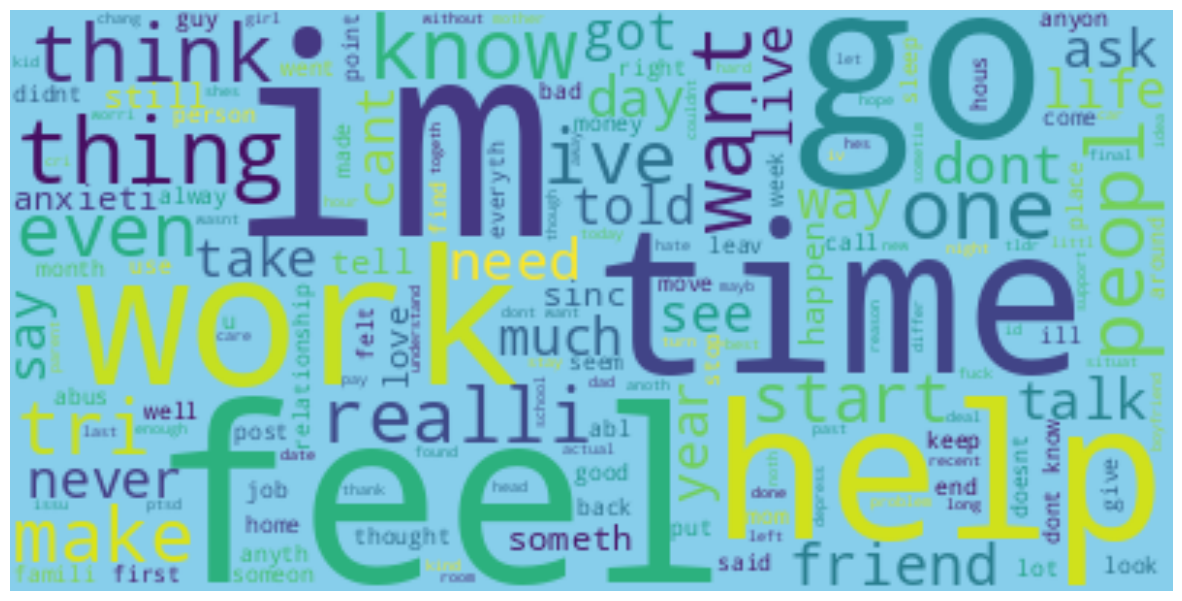

In [100]:

text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="skyblue").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Data Modeling
#Stress_Sentiment_Detection_Model


The label column in this dataset contains labels as 0 and 1. 0 means no stress, and 1 means stress.
use Stress and No stress labels instead of 1 and 0. So lets prepare this column accordingly and
select the text and label columns for the process of training a machine learning model:

data["label"] = data["label"].map({0: "Unstressed", 1: "Stressed"})
data = data[["text", "label"]]
print(data.head())

In [101]:
posts["meaning"] = data["label"].map({0: "Unstressed", 1: "Stressed"})
posts.head()

<ipython-input-101-6cc086487946>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts["meaning"] = data["label"].map({0: "Unstressed", 1: "Stressed"})


,text,sentiment,meaning
0,"He said he had not felt that way before, sugge...",-0.002742,Stressed
1,"Hey there r/assistance, Not sure if this is th...",0.292857,Unstressed
2,My mom then hit me with the newspaper and it s...,0.011894,Stressed
3,"until i met my new boyfriend, he is amazing, h...",0.141671,Stressed
4,October is Domestic Violence Awareness Month a...,-0.204167,Stressed


#Plotting count of the stressed and unstressed data

<ipython-input-102-dd778d96c863>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='meaning',data=posts, palette="PuBu")


<Axes: xlabel='meaning', ylabel='count'>

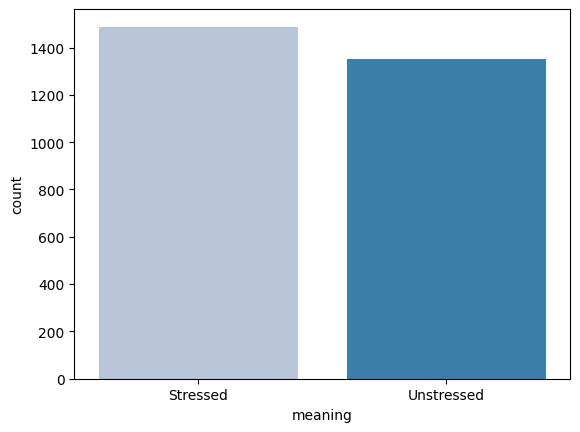

In [102]:
sns.countplot(x='meaning',data=posts, palette="PuBu")


x = np.array(data["text"])
y = np.array(data["label"])

Assign variables :
x = features and y = target

In [103]:
x = posts.text
y = posts.meaning

#Feature Extraction

In [104]:
cv = CountVectorizer(stop_words="english")

X = cv.fit_transform(x)

#Split the dataset into training and test sets



In [105]:

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)


#GaussianNB---> When the features are continuous
#CategoricalNB---> When the data is categorical
#MultinomialNB---> Applied to text data

In [67]:


mb = MultinomialNB()

m1 = mb.fit(xtrain,ytrain).predict(xtest)
print("Model Accuracy is {p}%".format(p = round(accuracy_score(m1,ytest)*100, 2)))

conf_1=confusion_matrix(ytest,m1)
print(conf_1)
print(classification_report(ytest,m1))

Model Accuracy is 72.04%
[[431  62]
 [200 244]]
              precision    recall  f1-score   support

    Stressed       0.68      0.87      0.77       493
  Unstressed       0.80      0.55      0.65       444

    accuracy                           0.72       937
   macro avg       0.74      0.71      0.71       937
weighted avg       0.74      0.72      0.71       937



#Logistic Regression

In [68]:


lr = LogisticRegression()
m2 = lr.fit(xtrain, ytrain).predict(xtest)


print("Model Accuracy is {p}%".format(p = round(accuracy_score(m2,ytest)*100, 2)))

conf_2=confusion_matrix(ytest,m2)
print(conf_2)
print(classification_report(ytest,m2))




Model Accuracy is 71.82%
[[365 128]
 [136 308]]
              precision    recall  f1-score   support

    Stressed       0.73      0.74      0.73       493
  Unstressed       0.71      0.69      0.70       444

    accuracy                           0.72       937
   macro avg       0.72      0.72      0.72       937
weighted avg       0.72      0.72      0.72       937



#Decision Tree Classifier

In [69]:

d = DecisionTreeClassifier()

m3 = d.fit(xtrain,ytrain).predict(xtest)
print("Model Accuracy is {p}%".format(p=round(accuracy_score(ytest, m3)*100, 2)))

conf_3 = confusion_matrix(ytest,m3)
print(conf_3)
print(classification_report(ytest,m3))



Model Accuracy is 58.48%
[[309 184]
 [205 239]]
              precision    recall  f1-score   support

    Stressed       0.60      0.63      0.61       493
  Unstressed       0.57      0.54      0.55       444

    accuracy                           0.58       937
   macro avg       0.58      0.58      0.58       937
weighted avg       0.58      0.58      0.58       937



#Random Forest Classifier

In [70]:

rf = RandomForestClassifier()

m4 = rf.fit(xtrain, ytrain).predict(xtest)

print("Model Accuracy is {p}%".format(p=round(accuracy_score(ytest, m4)*100, 2)))

conf_4 = confusion_matrix(ytest,m4)
print(conf_4)
print(classification_report(ytest,m4))


Model Accuracy is 70.86%
[[391 102]
 [171 273]]
              precision    recall  f1-score   support

    Stressed       0.70      0.79      0.74       493
  Unstressed       0.73      0.61      0.67       444

    accuracy                           0.71       937
   macro avg       0.71      0.70      0.70       937
weighted avg       0.71      0.71      0.71       937



#Support Vector Classifier

In [71]:

svc = SVC(kernel='linear', random_state=0)

m5 = svc.fit(xtrain,ytrain).predict(xtest)
print("Model Accuracy is {p}%".format(p=round(accuracy_score(ytest, m5)*100, 2)))
conf_5 = confusion_matrix(ytest,m5)
print(conf_5)
print(classification_report(ytest,m5))



Model Accuracy is 68.41%
[[343 150]
 [146 298]]
              precision    recall  f1-score   support

    Stressed       0.70      0.70      0.70       493
  Unstressed       0.67      0.67      0.67       444

    accuracy                           0.68       937
   macro avg       0.68      0.68      0.68       937
weighted avg       0.68      0.68      0.68       937



#Bernoulli Naive Bayes Algorithm

Best algorithm for binary classification problems.



In [106]:

b_nb = BernoulliNB()

m6 = b_nb.fit(xtrain, ytrain).predict(xtest)
print("Model Accuracy is {p}%".format(p=round(accuracy_score(ytest, m6)*100, 2)))

conf_6 = confusion_matrix(ytest,m6)
print(conf_6)
print(classification_report(ytest,m6))




Model Accuracy is 73.32%
[[426  67]
 [183 261]]
              precision    recall  f1-score   support

    Stressed       0.70      0.86      0.77       493
  Unstressed       0.80      0.59      0.68       444

    accuracy                           0.73       937
   macro avg       0.75      0.73      0.72       937
weighted avg       0.75      0.73      0.73       937



#Test the performance of the Bernoulli Naive Bayes model on some random sentences on mental health

In [108]:

user_input = input("Enter a Text: ")

data = cv.transform([user_input]).toarray()

output = b_nb.predict(data)
output


Enter a Text: I feel anxious


array(['Stressed'], dtype='<U10')